## Retrieve data using Spark

In [1]:
#Dependencies
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

In [27]:
#Importing packeges to retrive data from  spark
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pathlib import Path
import time
import findspark
findspark.init()
import matplotlib.pyplot as plt
import scipy.stats as st
plt.style.use("ggplot") # ggplot provides a vizualization style I find usuful but if its not allow please comment it out.

In [3]:
# Initialize Spark session
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()
#Define Path 
data0 = Path('Resources/movies_dataset_0.csv').resolve()
data1 = Path('Resources/movies_dataset_1.csv').resolve()
data2 = Path('Resources/movies_dataset_2.csv').resolve()
data3 = Path('Resources/movies_dataset_3.csv').resolve()

# Read the CSV file using the absolute path
df0 = spark.read.csv(
    str(data0), 
    sep=",", 
    header=True, 
    inferSchema=True, 
    quote='"',    # Handles quoted strings
    escape='"',   # Escape character for embedded quotes
    multiLine=True  # Handles multiline fields in case of long text
)

df1 = spark.read.csv(
    str(data1), 
    sep=",", 
    header=True, 
    inferSchema=True, 
    quote='"',    
    escape='"',   
    multiLine=True  
)
df2 = spark.read.csv(
    str(data2), 
    sep=",", 
    header=True, 
    inferSchema=True, 
    quote='"',    
    escape='"',   
    multiLine=True  
)
df3 = spark.read.csv(
    str(data3), 
    sep=",", 
    header=True, 
    inferSchema=True, 
    quote='"',    
    escape='"',   
    multiLine=True  
)
# #Merge the Dataframes using union
merged_df = df0.union(df1).union(df2).union(df3)
merged_df.show()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/18 14:08:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+----------+--------------------+-------+--------------------+---------+----------+----------+-----------+----------------------+-----------------+---------+----------+-----------------+-------------------+--------------------+--------------------+---------+----------+----------+------------------+--------------------+------------+-------+
|   imdb_id|               title|runtime|            overview|    rated|imdb_votes|popularity|imdb_rating|rotten_tomatoes_rating|metacritic_rating|   budget|   revenue|financial_success|             star_1|              star_2|              star_3|  genre_1|   genre_2|   genre_3|        director_1|          director_2|release_year|outcome|
+----------+--------------------+-------+--------------------+---------+----------+----------+-----------+----------------------+-----------------+---------+----------+-----------------+-------------------+--------------------+--------------------+---------+----------+----------+------------------+-----------------

In [4]:
# Create our temporary view
merged_df.createOrReplaceTempView('movies')

In [5]:
#Actor participation per movies
actors =spark.sql("""
SELECT star_1,
       count(*) AS number_of_stars
FROM movies
GROUP BY star_1
ORDER BY number_of_stars DESC
""")
actors.show()

+--------------------+---------------+
|              star_1|number_of_stars|
+--------------------+---------------+
|           Tom Hanks|             23|
|        Adam Sandler|             23|
|          Tom Cruise|             22|
|       Mark Wahlberg|             21|
|  Sylvester Stallone|             21|
|        Nicolas Cage|             20|
|        Keanu Reeves|             19|
|      Dwayne Johnson|             18|
|Arnold Schwarzene...|             17|
|         Johnny Depp|             17|
|   Denzel Washington|             16|
|        Bruce Willis|             16|
|          Will Smith|             16|
|   Leonardo DiCaprio|             15|
|          Jim Carrey|             15|
|         Ben Affleck|             14|
|       Ryan Reynolds|             13|
|      Robert De Niro|             13|
|           Brad Pitt|             13|
|     Jake Gyllenhaal|             12|
+--------------------+---------------+
only showing top 20 rows



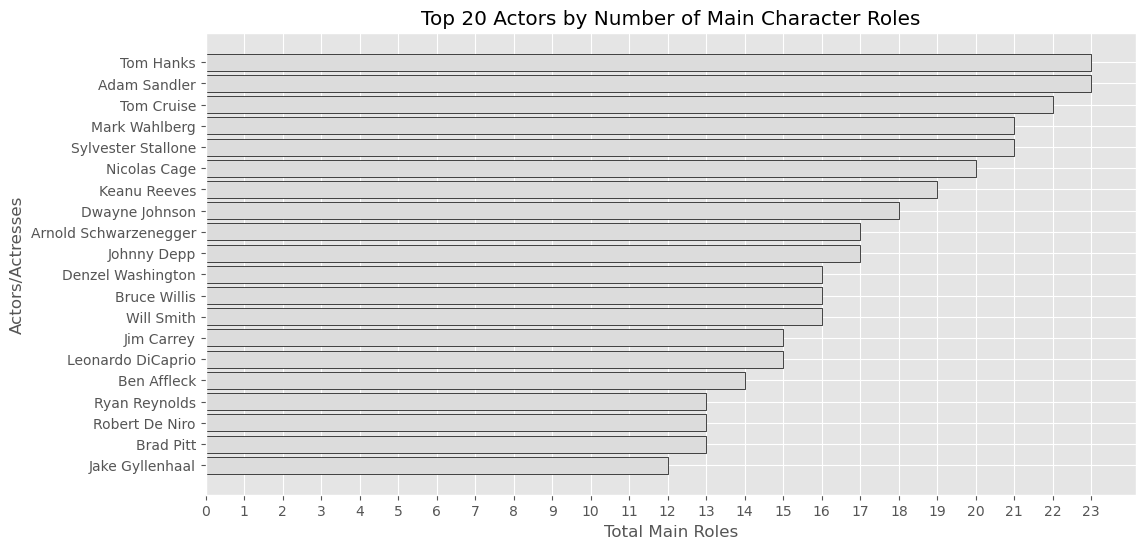

In [28]:
#Actor participation per movies vizualization 
# Convert Spark DataFrame to Pandas DataFrame
actors_df = actors.toPandas()
# Sort the DataFrame in descending order and limit to top N (number)
N = 20 
top_actors_df = actors_df.sort_values(by='number_of_stars', ascending=False).head(N)
# Create the bar chart
plt.figure(figsize=(12, 6))
plt.barh(top_actors_df['star_1'], top_actors_df['number_of_stars'], color='gainsboro', edgecolor='black')
plt.xlabel('Total Main Roles')
plt.ylabel('Actors/Actresses')
plt.title(f'Top {N} Actors by Number of Main Character Roles')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest stars on top

# Add more tick marks
max_stars = max(top_actors_df['number_of_stars'])
plt.xticks(np.arange(0, max_stars + 1, 1))

# Show the plot
plt.show()


In [8]:
#Highest-rated movies
high_rated_movies_query = spark.sql("""
SELECT title,
        imdb_rating
FROM movies
ORDER BY imdb_rating DESC
""")
high_rated_movies_query.show(truncate=False)

+-------------------------------------------------+-----------+
|title                                            |imdb_rating|
+-------------------------------------------------+-----------+
|The Shawshank Redemption                         |9.3        |
|The Godfather                                    |9.2        |
|The Dark Knight                                  |9.0        |
|The Lord of the Rings: The Return of the King    |9.0        |
|The Godfather Part II                            |9.0        |
|Schindler's List                                 |9.0        |
|12 Angry Men                                     |9.0        |
|The Lord of the Rings: The Fellowship of the Ring|8.9        |
|Pulp Fiction                                     |8.9        |
|The Lord of the Rings: The Two Towers            |8.8        |
|Fight Club                                       |8.8        |
|Forrest Gump                                     |8.8        |
|Inception                              

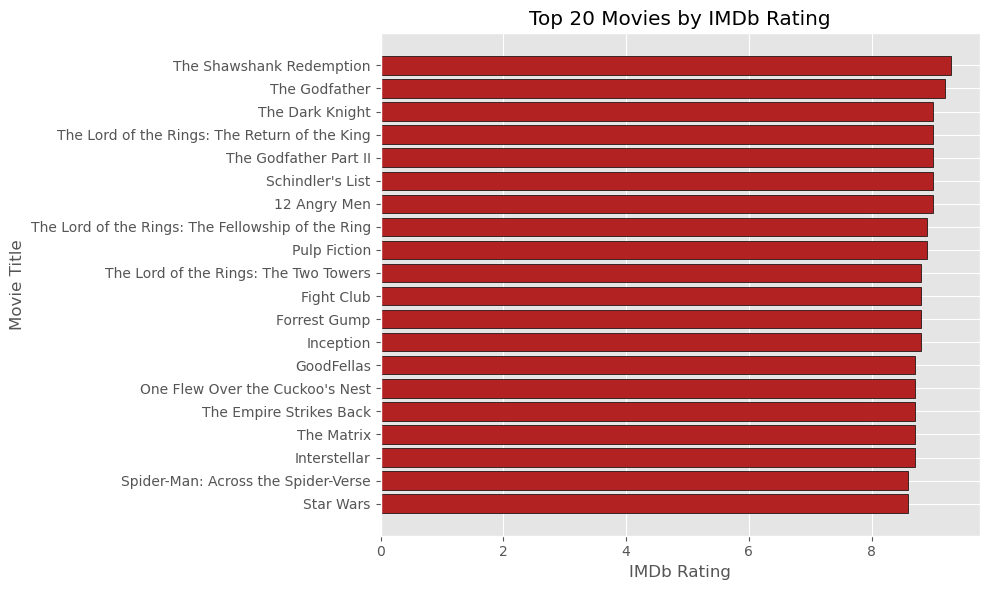

In [29]:
# Convert Spark DataFrame to Pandas DataFrame
high_rated_movies_df = high_rated_movies_query.toPandas()
# Sort the DataFrame in descending order and limit to top N (number)
N = 20  
high_rated_movies_df = high_rated_movies_df.sort_values(by='imdb_rating', ascending=False).head(N)

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.barh(high_rated_movies_df['title'], high_rated_movies_df['imdb_rating'], color='firebrick', edgecolor='black')
plt.xlabel('IMDb Rating')
plt.ylabel('Movie Title')
plt.title(f'Top {N} Movies by IMDb Rating')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest stars on top
plt.tight_layout()

# Show the plot
plt.show()

In [10]:
#Lowest-rated movies
lowest_rated_movies_query = spark.sql("""
SELECT title,
        imdb_rating
FROM movies
ORDER BY imdb_rating ASC
""")
lowest_rated_movies_query.show(truncate=False)

+---------------------------------------+-----------+
|title                                  |imdb_rating|
+---------------------------------------+-----------+
|Son of the Mask                        |2.3        |
|Cosmic Sin                             |2.5        |
|Dragonball Evolution                   |2.5        |
|Meet the Spartans                      |2.8        |
|Winnie the Pooh: Blood and Honey       |2.9        |
|Left Behind                            |3.1        |
|Jack and Jill                          |3.3        |
|The Emoji Movie                        |3.4        |
|Fifty Shades of Black                  |3.5        |
|Dance Flick                            |3.6        |
|Mortal Kombat: Annihilation            |3.6        |
|Jaws 3-D                               |3.7        |
|Superman IV: The Quest for Peace       |3.7        |
|Exorcist II: The Heretic               |3.8        |
|The Adventures of Sharkboy and Lavagirl|3.8        |
|Batman & Robin             

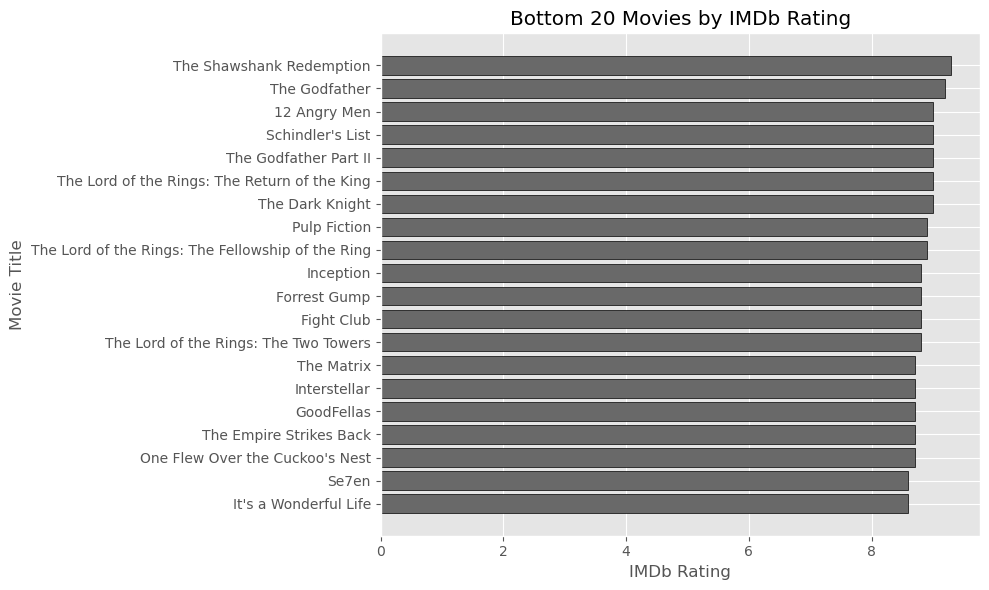

In [30]:
# Convert Spark DataFrame to Pandas DataFrame
lowest_rated_movies_df = lowest_rated_movies_query.toPandas()

# Sort the DataFrame in descending order and limit to top N (number)
N = 20  
lowest_rated_movies_df = lowest_rated_movies_df.sort_values(by='imdb_rating', ascending=False).head(N)

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.barh(lowest_rated_movies_df['title'], lowest_rated_movies_df['imdb_rating'], color='dimgrey', edgecolor='black')
plt.xlabel('IMDb Rating')
plt.ylabel('Movie Title')
plt.title(f'Bottom {N} Movies by IMDb Rating')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest stars on top
plt.tight_layout()
# Show the plot
plt.show()

In [13]:
#Movies per IMDB_Rating
movies_per_imdb_rating_query =spark.sql("""
SELECT imdb_rating, COUNT(*) AS number_of_movies
FROM movies
GROUP BY imdb_rating
ORDER BY number_of_movies DESC          
""")
movies_per_imdb_rating_query.show(20)

+-----------+----------------+
|imdb_rating|number_of_movies|
+-----------+----------------+
|        6.5|              97|
|        6.6|              96|
|        6.3|              94|
|        7.3|              93|
|        6.4|              87|
|        6.7|              79|
|        7.0|              79|
|        7.2|              76|
|        7.1|              74|
|        6.2|              71|
|        7.4|              68|
|        6.1|              68|
|        6.9|              68|
|        7.6|              66|
|        7.5|              65|
|        6.8|              65|
|        7.8|              57|
|        7.7|              56|
|        5.8|              55|
|        5.9|              48|
+-----------+----------------+
only showing top 20 rows



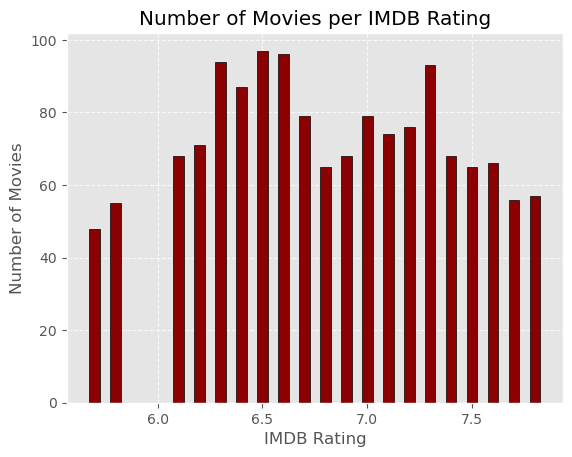

In [31]:
# Convert Spark DataFrame to Pandas DataFrame
movies_per_imdb_rating_df = movies_per_imdb_rating_query.toPandas()

# Sort the DataFrame in descending order and limit to top N (number)
N = 20  
movies_per_imdb_rating_df = movies_per_imdb_rating_df.sort_values(by='number_of_movies', ascending=False).head(N)

# Create the bar plot
plt.bar(movies_per_imdb_rating_df['imdb_rating'], movies_per_imdb_rating_df['number_of_movies'], width=0.05, color= 'darkred', edgecolor='black')
plt.xlabel("IMDB Rating")
plt.ylabel("Number of Movies")
plt.title("Number of Movies per IMDB Rating")
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

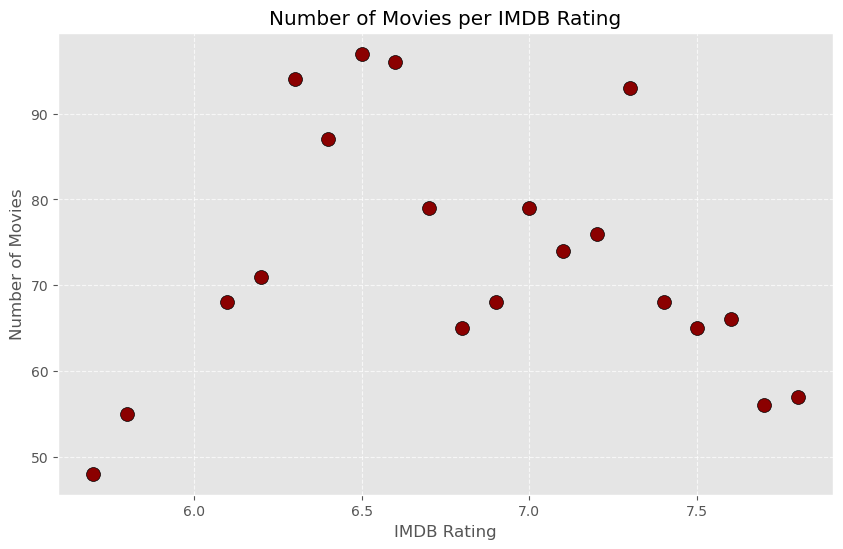

In [32]:
# Sort the DataFrame in descending order and limit to top N (number)
N = 20  
movies_per_imdb_rating_df = movies_per_imdb_rating_df.sort_values(by='number_of_movies', ascending=False).head(N)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(movies_per_imdb_rating_df['imdb_rating'], movies_per_imdb_rating_df['number_of_movies'], color='darkred', edgecolor='black', s=100)  # 's' controls the size of the points
plt.xlabel("IMDB Rating")
plt.ylabel("Number of Movies")
plt.title("Number of Movies per IMDB Rating")
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

#Here we have another visualization but with a scatter plot to check for clusters easier.

In [9]:
#Movies with finantial success
spark.sql("""
SELECT title, revenue, budget
FROM movies
WHERE financial_success = true
ORDER BY  revenue  DESC   
""").show(truncate=False)

+------------------------------+----------+---------+
|title                         |revenue   |budget   |
+------------------------------+----------+---------+
|Avatar                        |2923706026|237000000|
|Avengers: Endgame             |2799439100|356000000|
|Avatar: The Way of Water      |2320250281|460000000|
|Titanic                       |2264162353|200000000|
|Avengers: Infinity War        |2052415039|300000000|
|Spider-Man: No Way Home       |1921847111|200000000|
|Jurassic World                |1671537444|150000000|
|The Lion King                 |1663000000|260000000|
|The Avengers                  |1518815515|220000000|
|Furious 7                     |1515400000|190000000|
|Top Gun: Maverick             |1488732821|170000000|
|Frozen II                     |1453683476|150000000|
|Barbie                        |1445638421|145000000|
|Avengers: Age of Ultron       |1405403694|365000000|
|The Super Mario Bros. Movie   |1362000000|100000000|
|Black Panther              

In [25]:
#Amount of movies per genre 
movies_per_genre_query = spark.sql("""
SELECT genre_1 AS genre, COUNT(*) AS number_of_movies
FROM movies
WHERE genre_1 IS NOT NULL
GROUP BY genre_1

UNION ALL

SELECT genre_2 AS genre, COUNT(*) AS number_of_movies
FROM movies
WHERE genre_2 IS NOT NULL
GROUP BY genre_2

UNION ALL

SELECT genre_3 AS genre, COUNT(*) AS number_of_movies
FROM movies
WHERE genre_3 IS NOT NULL
GROUP BY genre_3

ORDER BY number_of_movies DESC
""")
movies_per_genre_query.show(10)


+----------+----------------+
|     genre|number_of_movies|
+----------+----------------+
|    Action|             769|
| Adventure|             527|
|     Drama|             357|
|    Comedy|             304|
|  Thriller|             284|
|     Drama|             254|
| Animation|             225|
|    Sci-Fi|             201|
|    Comedy|             200|
|     Drama|             164|
+----------+----------------+
only showing top 10 rows



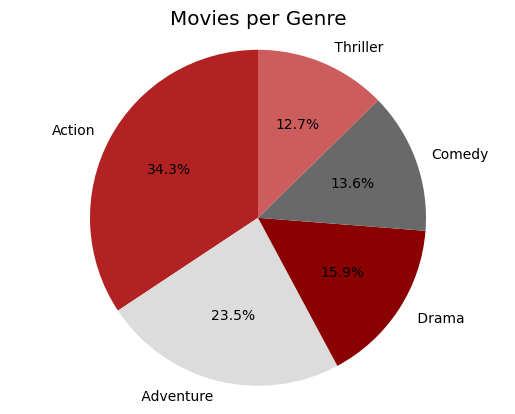

In [34]:
# Convert Spark DataFrame to Pandas DataFrame
movies_per_genre_df = movies_per_genre_query.toPandas()

# Sort the DataFrame in descending order and limit to top N (number)
N = 5
movies_per_genre_df = movies_per_genre_df.sort_values(by='number_of_movies', ascending=False).head(N)
plt.pie(movies_per_genre_df['number_of_movies'], labels=movies_per_genre_df['genre'], autopct='%1.1f%%', startangle=90, colors=['firebrick','gainsboro','darkred','dimgrey','indianred'])
plt.axis('equal')  # Ensure a circular pie chart
plt.title('Movies per Genre')
# Show the plot
plt.show()

## Clean, normalize, and standardize data before modeling

In [11]:
# Converting merged df from Spark into a Pandas DataFrame
movies_df = merged_df.toPandas()
movies_df.head()

,imdb_id,title,runtime,overview,rated,imdb_votes,popularity,imdb_rating,rotten_tomatoes_rating,metacritic_rating,...,star_1,star_2,star_3,genre_1,genre_2,genre_3,director_1,director_2,release_year,outcome
0,tt0094721,Beetlejuice,92 min,A newly dead New England couple seeks help fro...,PG,"348,874",941.557,7.5,86.0,70.0,...,Alec Baldwin,Geena Davis,Michael Keaton,Comedy,Fantasy,None,Tim Burton,None,1988,True
1,tt27682129,Prey,100 min,A young couple is compelled to leave their Chr...,R,"233,550",436.919,7.1,94.0,71.0,...,Amber Midthunder,Dakota Beavers,Dane DiLiegro,Action,Adventure,Horror,Dan Trachtenberg,None,2024,False
2,tt0295701,xXx,124 min,Xander Cage is your standard adrenaline junkie...,PG-13,"187,525",369.083,5.8,48.0,48.0,...,Vin Diesel,Asia Argento,Marton Csokas,Action,Adventure,Thriller,Rob Cohen,None,2002,False
3,tt4154756,Avengers: Infinity War,149 min,As the Avengers and their allies have continue...,PG-13,"1,226,533",270.163,8.4,85.0,68.0,...,Robert Downey Jr.,Chris Hemsworth,Mark Ruffalo,Action,Adventure,Sci-Fi,Anthony Russo,Joe Russo,2018,True
4,tt23778968,Thelma,116 min,When 93-year-old Thelma Post gets duped by a p...,Not Rated,"37,145",263.208,7.0,92.0,74.0,...,Eili Harboe,Kaya Wilkins,Henrik Rafaelsen,Drama,Fantasy,Horror,Joachim Trier,None,2024,True


In [12]:
#Checking columns
movies_df.columns

Index(['imdb_id', 'title', 'runtime', 'overview', 'rated', 'imdb_votes',
       'popularity', 'imdb_rating', 'rotten_tomatoes_rating',
       'metacritic_rating', 'budget', 'revenue', 'financial_success', 'star_1',
       'star_2', 'star_3', 'genre_1', 'genre_2', 'genre_3', 'director_1',
       'director_2', 'release_year', 'outcome'],
      dtype='object')

In [13]:
#Dropping unncesary columns for the model
movies_df.drop([
    'imdb_id','title', 'overview','imdb_votes','popularity',
    'imdb_rating', 'rotten_tomatoes_rating', 'metacritic_rating',
      'revenue','financial_success',

     ], axis=1, inplace=True)

In [14]:
#Checking data types
movies_df.dtypes

runtime         object
rated           object
budget           int32
star_1          object
star_2          object
star_3          object
genre_1         object
genre_2         object
genre_3         object
director_1      object
director_2      object
release_year     int32
outcome           bool
dtype: object

In [15]:
#Organizing columns names and coverting the 'outcome' column into a boolean
movies_df = movies_df[['release_year','runtime', 'rated','budget', 'star_1', 'star_2', 'star_3', 'genre_1','genre_2','genre_3', 'director_1','director_2','outcome']]
movies_df['outcome'] = movies_df['outcome'].astype(int)
movies_df.head(3)

,release_year,runtime,rated,budget,star_1,star_2,star_3,genre_1,genre_2,genre_3,director_1,director_2,outcome
0,1988,92 min,PG,15000000,Alec Baldwin,Geena Davis,Michael Keaton,Comedy,Fantasy,None,Tim Burton,None,1
1,2024,100 min,R,0,Amber Midthunder,Dakota Beavers,Dane DiLiegro,Action,Adventure,Horror,Dan Trachtenberg,None,0
2,2002,124 min,PG-13,70000000,Vin Diesel,Asia Argento,Marton Csokas,Action,Adventure,Thriller,Rob Cohen,None,0


In [16]:
#Extracting the string(min) from the 'runtime' column
def runtime_cleaner (string):
    minutes = string.split(" ")[0]
    return int(minutes)

movies_df['runtime'] = movies_df['runtime'].map(runtime_cleaner)
movies_df.head(3)

,release_year,runtime,rated,budget,star_1,star_2,star_3,genre_1,genre_2,genre_3,director_1,director_2,outcome
0,1988,92,PG,15000000,Alec Baldwin,Geena Davis,Michael Keaton,Comedy,Fantasy,None,Tim Burton,None,1
1,2024,100,R,0,Amber Midthunder,Dakota Beavers,Dane DiLiegro,Action,Adventure,Horror,Dan Trachtenberg,None,0
2,2002,124,PG-13,70000000,Vin Diesel,Asia Argento,Marton Csokas,Action,Adventure,Thriller,Rob Cohen,None,0


In [17]:
# Identify categorical columns
movies_categorical = movies_df.select_dtypes(include=["object"]).columns.tolist()

In [18]:
#Checking my categorical columns
movies_categorical

['rated',
 'star_1',
 'star_2',
 'star_3',
 'genre_1',
 'genre_2',
 'genre_3',
 'director_1',
 'director_2']

In [19]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse_output=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(movies_df[movies_categorical]))

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names_out(movies_categorical)

# Display the first few rows of the encoded DataFrame
encode_df.head()

,rated_Approved,rated_G,rated_GP,rated_N/A,rated_NC-17,rated_Not Rated,rated_PG,rated_PG-13,rated_Passed,rated_R,...,director_2_ Tyler Gillett,director_2_ Vicky Jenson,"director_2_ Vicky Jenson, Rob Letterman",director_2_ Walt Dohrn,"director_2_ Warren Coleman, Judy Morris","director_2_ Wilfred Jackson, Hamilton Luske",director_2_ Will Merrick,director_2_ Will Speck,"director_2_ Wolfgang Reitherman, Art Stevens",director_2_None
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [20]:
# Merge one-hot encoded features and drop the originals
movies_df = movies_df.merge(encode_df,left_index=True, right_index=True)
movies_df = movies_df.drop(movies_categorical, axis=1)
movies_df.head()

,release_year,runtime,budget,outcome,rated_Approved,rated_G,rated_GP,rated_N/A,rated_NC-17,rated_Not Rated,...,director_2_ Tyler Gillett,director_2_ Vicky Jenson,"director_2_ Vicky Jenson, Rob Letterman",director_2_ Walt Dohrn,"director_2_ Warren Coleman, Judy Morris","director_2_ Wilfred Jackson, Hamilton Luske",director_2_ Will Merrick,director_2_ Will Speck,"director_2_ Wolfgang Reitherman, Art Stevens",director_2_None
0,1988,92,15000000,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2024,100,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2002,124,70000000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2018,149,300000000,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2024,116,5000000,1,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [21]:
#Checking columns
column_list = movies_df.columns.tolist()
column_list[0:5]

['release_year', 'runtime', 'budget', 'outcome', 'rated_Approved']